Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

Load dataset

In [2]:
train_df = pd.read_csv('dataset/final_df.csv')
test_df = pd.read_csv('dataset/test.csv')

In [3]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [5]:
X.shape

(891, 39)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 39), (179, 39), (712,), (179,))

In [7]:
def evaluate_model(true, predicted):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted, average = 'weighted')
    recall = recall_score(true, predicted, average = 'weighted')
    f1 = f1_score(true, predicted, average = 'weighted')
    return accuracy, precision, recall, f1

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost Classifier": XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss'),
    # "CatBoost Classifier": CatBoostClassifier(verbose=0),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Navie Bayes": GaussianNB()

}

model_list = []
accuracy_list = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(y_train, y_train_pred)
    test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(y_test, y_test_pred)
    
    print(f"{name}")
    model_list.append(name)
    
    print('Training Metrics:')
    print(f"- Accuracy: {train_accuracy:.4f}")
    print(f"- Precision: {train_precision:.4f}")
    print(f"- Recall: {train_recall:.4f}")
    print(f"- F1 Score: {train_f1:.4f}")
    
    print('Testing Metrics:')
    print(f"- Accuracy: {test_accuracy:.4f}")
    print(f"- Precision: {test_precision:.4f}")
    print(f"- Recall: {test_recall:.4f}")
    print(f"- F1 Score: {test_f1:.4f}")
    
    accuracy_list.append(test_accuracy)
    print("=" * 40)

Logistic Regression
Training Metrics:
- Accuracy: 0.9902
- Precision: 0.9903
- Recall: 0.9902
- F1 Score: 0.9901
Testing Metrics:
- Accuracy: 0.9888
- Precision: 0.9888
- Recall: 0.9888
- F1 Score: 0.9888
Ridge Classifier
Training Metrics:
- Accuracy: 0.9916
- Precision: 0.9917
- Recall: 0.9916
- F1 Score: 0.9916
Testing Metrics:
- Accuracy: 0.9888
- Precision: 0.9888
- Recall: 0.9888
- F1 Score: 0.9888
K-Nearest Neighbors
Training Metrics:
- Accuracy: 0.9607
- Precision: 0.9608
- Recall: 0.9607
- F1 Score: 0.9605
Testing Metrics:
- Accuracy: 0.9050
- Precision: 0.9049
- Recall: 0.9050
- F1 Score: 0.9049
Decision Tree
Training Metrics:
- Accuracy: 0.9986
- Precision: 0.9986
- Recall: 0.9986
- F1 Score: 0.9986
Testing Metrics:
- Accuracy: 0.9944
- Precision: 0.9945
- Recall: 0.9944
- F1 Score: 0.9944
Random Forest
Training Metrics:
- Accuracy: 0.9986
- Precision: 0.9986
- Recall: 0.9986
- F1 Score: 0.9986
Testing Metrics:
- Accuracy: 0.9832
- Precision: 0.9833
- Recall: 0.9832
- F1 Scor

In [9]:
pd.DataFrame(list(zip(model_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

,Model Name,Accuracy
3,Decision Tree,0.994413
0,Logistic Regression,0.988827
1,Ridge Classifier,0.988827
6,AdaBoost Classifier,0.988827
7,SVM,0.988827
4,Random Forest,0.983240
5,XGBoost Classifier,0.983240
8,Gradient Boosting Classifier,0.983240
9,Navie Bayes,0.983240
2,K-Nearest Neighbors,0.905028


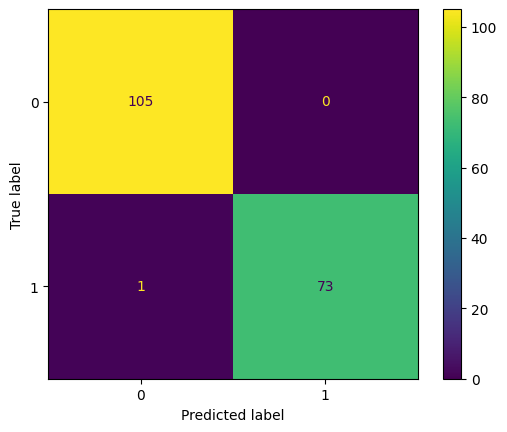

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
best_model = DecisionTreeClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       1.00      0.99      0.99        74

    accuracy                           0.99       179
   macro avg       1.00      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



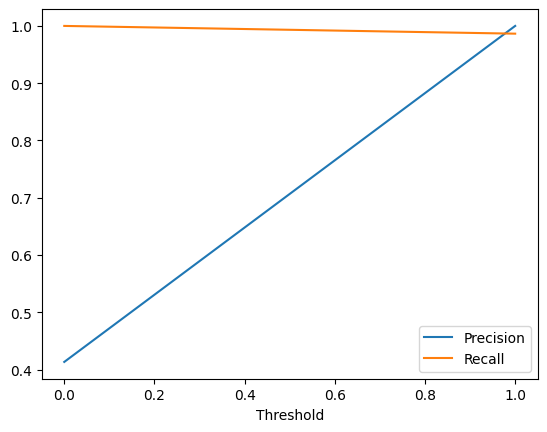

In [12]:
from sklearn.metrics import precision_recall_curve

# Example: Find threshold for optimal precision-recall balance
probabilities = best_model.predict_proba(X_test)[:, 1]  # Get probability for positive class
precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)

# Plot to find a balance (precision vs recall)
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

ROC-AUC Score: 0.9932432432432432


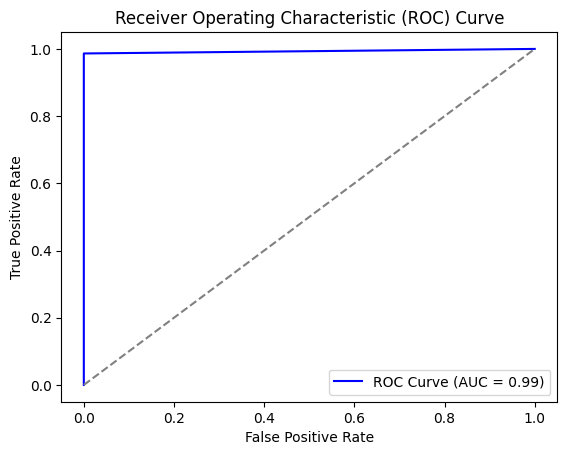

In [14]:
y_probs = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC-AUC Score:", roc_auc)
# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize each model
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV for each model
grid_search_dt = GridSearchCV(estimator=dt_model, 
                              param_grid=param_grid_dt, 
                              scoring='accuracy', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

grid_search_rf = GridSearchCV(estimator=rf_model, 
                              param_grid=param_grid_rf, 
                              scoring='accuracy', 
                              cv=5, 
                              verbose=2, 
                              n_jobs=-1)

# Fit GridSearchCV for DecisionTreeClassifier
grid_search_dt.fit(X_train, y_train)
print("Best Parameters for DecisionTreeClassifier:", grid_search_dt.best_params_)
print("Best CV Score for DecisionTreeClassifier:", grid_search_dt.best_score_)

# Fit GridSearchCV for RandomForestClassifier
grid_search_rf.fit(X_train, y_train)
print("Best Parameters for RandomForestClassifier:", grid_search_rf.best_params_)
print("Best CV Score for RandomForestClassifier:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best CV Score for DecisionTreeClassifier: 0.988761942283069
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score for RandomForestClassifier: 0.9873633408844678
